In [23]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
# import warnings
# warnings.filterwarnings('ignore')
# %matplotlib inline

import cv2
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [24]:
data = "/home/raphaelpeabody/Downloads/UTKFace"

In [25]:
image_paths = []
age_labels = []
gender_labels = []
race_labels = []

for filename in tqdm(os.listdir(data)):
    image_path = os.path.join(data, filename)
    try:
        temp = filename.split('_')
        age = int(temp[0])
        gender = int(temp[1])
        race = int(temp[2])
    except ValueError:
        print("Skipping file:", filename)
        continue
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)



  0%|          | 0/23709 [00:00<?, ?it/s]

Skipping file: rename.bash
Skipping file: 39_1_20170116174525125.jpg
Skipping file: 61_1_20170109150557335.jpg
Skipping file: 61_1_20170109142408075.jpg


In [26]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race'] = image_paths, age_labels, gender_labels, race_labels
df.head()

,image,age,gender,race
0,/home/raphaelpeabody/Downloads/UTKFace/7_1_4_2...,7,1,4
1,/home/raphaelpeabody/Downloads/UTKFace/26_1_0_...,26,1,0
2,/home/raphaelpeabody/Downloads/UTKFace/18_1_0_...,18,1,0
3,/home/raphaelpeabody/Downloads/UTKFace/22_1_3_...,22,1,3
4,/home/raphaelpeabody/Downloads/UTKFace/28_1_0_...,28,1,0


In [27]:
gender_dict = {0:'Male', 1:'Female'}
race_dict = {0:'White', 1:'Black', 2:'Asian', 3:'Indian', 4:'Other'}

## feature extraction

In [28]:
X = np.load('../X.npy')

## model setup

In [29]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
y_race = np.array(df['race'])

In [30]:
samples_per_group = np.array(df['race'].value_counts().sort_index())
total_samples = sum(samples_per_group)
print('total samples:', total_samples)
weights_per_group = total_samples / (len(samples_per_group) * np.array(samples_per_group))
print('sum of weights over all samples:', sum(weights_per_group*samples_per_group))

sample_weights = np.array([weights_per_group[race] for race in df['race']])

print(y_race)
print(sample_weights)

total samples: 23705
sum of weights over all samples: 23705.0
[4 0 0 ... 0 0 0]
[2.80200946 0.47043064 0.47043064 ... 0.47043064 0.47043064 0.47043064]


In [31]:
input_shape = (128,128,1)

In [32]:
inputs = Input((input_shape))

conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)

conv_2 = Conv2D(32, kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)

conv_3 = Conv2D(32, kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)

conv_4 = Conv2D(32, kernel_size=(3,3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

flatten = Flatten()(maxp_4)

# Fully connected layers
# dense_1 = Dense(256, activation = 'relu')(flatten)
dense_2 = Dense(256, activation = 'relu')(flatten)
# dense_3 = Dense(256, activation = 'relu')(flatten)

# dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)
# dropout_3 = Dropout(0.3)(dense_3)

# output_1 = Dense(1, activation = 'sigmoid', name = 'gender_out')(dropout_1)
output_2 = Dense(1, activation = 'relu', name = 'age_out')(dropout_2)
# output_3 = Dense(1, activation = 'relu', name = 'race_out')(dropout_3)

# model = Model(inputs = [inputs], outputs = [output_1, output_2, output_3])
# model = Model(inputs = [inputs], outputs = [output_1, output_2])
model = Model(inputs = [inputs], outputs = [output_2])

# model.compile(loss = ['binary_crossentropy', 'mae'], optimizer = 'adam', metrics = ['accuracy','mae'])
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['mae'])

2024-05-13 17:34:13.645244: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-13 17:34:13.737680: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [33]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ age_out (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,489 (1.23 MB)

 Trainable params: 323,489 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

## training

In [34]:
history = model.fit(x = X, y = [y_age], sample_weight=sample_weights, batch_size=32, epochs = 30, validation_split = 0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 48s 80ms/step - loss: 15.3874 - mae: 16.9234 - val_loss: 12.3122 - val_mae: 13.3559
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - loss: 11.8434 - mae: 13.1910 - val_loss: 9.6982 - val_mae: 11.0333
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - loss: 10.0838 - mae: 11.2882 - val_loss: 8.9889 - val_mae: 10.2193
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - loss: 9.2943 - mae: 10.2814 - val_loss: 8.3213 - val_mae: 9.4287
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - loss: 8.5784 - mae: 9.5889 - val_loss: 7.8126 - val_mae: 8.7770
Epoch 6/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - loss: 7.9349 - mae: 8.8698 - val_loss: 7.5635 - val_mae: 8.5768
Epoch 7/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - loss: 7.6126 - mae: 8.5160 - val_loss: 7.8593 - val_mae: 8.8759
Epoch 8/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - loss: 7.6440 - mae: 8.5449 - val_loss: 7.2601 - val_mae: 8.2117
Epoch 9/30
593/593 ━━━━━━━━━━

In [35]:
# # Plot results for gender
# acc = history.history['gender_out_accuracy']
# val_acc = history.history['val_gender_out_accuracy']
# epochs = range(len(acc))

# plt.plot(epochs, acc, 'b', label = 'Training accuracy')
# plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
# plt.title('Accuracy graph')
# plt.legend()
# plt.figure()

# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(len(acc))

# plt.plot(epochs, loss, 'b', label = 'Training loss')
# plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
# plt.title('Loss graph (gender)')
# plt.legend()
# plt.figure()

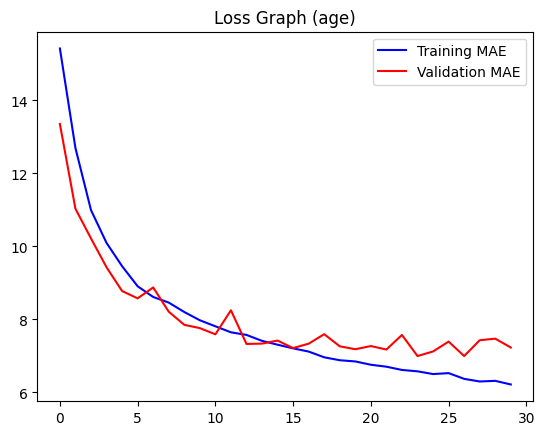

In [36]:
# Plot results for age
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph (age)')
plt.legend()
plt.show()

In [38]:
model.save('reweighted_loss.h5')